In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler

#Homework 3

#Function to load all activity data
#Citations: Utilized ChatGPT to provide function and try-catch statement structure. Also used GPT for debugging errors.
def load_activity_data(base_folder, activity_folder, num_datasets):
    data_frames = []
    for i in range(1, num_datasets + 1):
        filename = "dataset" + str(i) + ".csv"
        filepath = base_folder + "/" + activity_folder + "/" + filename
        try:
            df = pd.read_csv(filepath, skiprows=5, names=["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"], on_bad_lines='skip')
            data_frames.append(df)
        except (pd.errors.ParserError, FileNotFoundError) as e:
            print("Error loading " + filepath + ": " + str(e))
    return data_frames

#Function to seperate train and test data
#Citations: Utilized ChatGPT to provide function structure and help with error debugging. 
def separate_train_test_data(data_frames, test_indices):
    train_data = []
    test_data = []
    for i in range(len(data_frames)):
        if i in test_indices:
            test_data.append(data_frames[i])
        else:
            train_data.append(data_frames[i])
    return train_data, test_data

#Dictionary of activity names and # of time-series datasets
activities = {
    "bending1": 7,
    "bending2": 6,
    "cycling": 15,
    "lying": 15,
    "sitting": 15,
    "standing": 15,
    "walking": 15
}

#Dictionary of activity names and indeces of time-series datasets used for testing set
test_indices = {
    "bending1": [0, 1],
    "bending2": [0, 1],
    "cycling": [0, 1, 2],
    "lying": [0, 1, 2],
    "sitting": [0, 1, 2],
    "standing": [0, 1, 2],
    "walking": [0, 1, 2]
}
train_data = []
test_data = []
base_folder = "AReM"

#Loading data into training and test data arrays
#Citations: Utilized ChatGPT for error debugging for for loop
all_data = {}
for activity, num_datasets in activities.items():
    data_frames = load_activity_data(base_folder, activity, num_datasets)
    train, test = separate_train_test_data(data_frames, test_indices[activity])
    all_data[activity] = {'train': train, 'test': test}
    train_data.extend(train)
    test_data.extend(test)

#Transformation of training and test data arrays into dataframes and then CSV files
#Citations: Utilized ChatGPT for to_csv and concat method structure
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)
train_file_path = "train_data.csv"
test_file_path = "test_data.csv"
train_df.to_csv(train_file_path, index=False)
test_df.to_csv(test_file_path, index=False)

print("I chose min, max, median, std, 1st_quartile, 3rd_quartile as time-domain features.\n")

#Function to extract time-domain features from time-series dataset columns
#Citations: Utilized ChatGPT for function structure and time-series features
def extract_features(df):
    features = {}
    for column in df.columns:
        features[column + '_min'] = df[column].min()
        features[column + '_max'] = df[column].max()
        features[column + '_mean'] = df[column].mean()
        features[column + '_median'] = df[column].median()
        features[column + '_std'] = df[column].std()
        features[column + '_1st_quartile'] = df[column].quantile(0.25)
        features[column + '_3rd_quartile'] = df[column].quantile(0.75)
    return features

combined_features = []

#Extracting features 
#Citations: Utilized ChatGPT for for-loop feature location structure
for data_frames in all_data.values():
    for df in data_frames['train'] + data_frames['test']:
        if not df.empty:
            instance_features = extract_features(df.iloc[:, 1:]) 
            combined_features.append(instance_features)

#Creating time-series feature dataframe and saving features to CSV file
features_df = pd.DataFrame(combined_features)
features_file_path = "time_domain_features.csv"
features_df.to_csv(features_file_path, index=False)

features_df = pd.read_csv("time_domain_features.csv")

def std_dev(data):
    return np.std(data)

#Function to calculate bootstrap confidence intervals
#Citation: Utilized ChatGPT to define bootstrap confidence interval function. I tried to use bootstrap and stats functions but unfortunately, I ran into some issues. 
#ChatGPT provided function structure to calculate bootstrap confidence intervals without the use of bootstrap packages. 
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.90):
    bootstrap_samples = np.zeros(num_bootstrap_samples)
    for i in range(num_bootstrap_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_samples[i] = std_dev(sample)
    lower_bound = np.percentile(bootstrap_samples, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_samples, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound

std_devs = {}
confidence_intervals = {}

#Function to calculate bootstrap confidence intervals
#Citation: Utilized ChatGPT to define bootstrap confidence interval function. I tried to use bootstrap and stats functions but unfortunately, I ran into some issues. 
#ChatGPT provided function structure to calculate bootstrap confidence intervals without the use of bootstrap packages. 
for column in features_df.columns:
    data = features_df[column].dropna()
    std_dev_value = std_dev(data)
    lower_bound, upper_bound = bootstrap_confidence_interval(data.values, num_bootstrap_samples=1000, confidence_level=0.90)
    std_devs[column] = std_dev_value
    confidence_intervals[column] = (lower_bound, upper_bound)

#Printing statements
#Citation: Utilized ChatGPT for printing structure
for column in features_df.columns:
    print("Feature: " + column)
    print("Standard Deviation: " + str(std_devs[column]))
    print("90% Bootstrap Confidence Interval: " + str(confidence_intervals[column]))
    print("\n")
    
#To decide on the most important time-domain features, I looked at average standard deviation of each of the time-series features.
#Citations: Utilized ChatGPT for structure of for loops and printing statements
feature_types = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
avg_std_devs = {}

#Calculation of average standard deviations for each time-domain feature
for feature_type in feature_types:
    type_features = [col for col in features_df.columns if feature_type in col]
    avg_std_devs[feature_type] = np.mean([std_devs[col] for col in type_features])

#Printing average standard deviations for each feature type
for feature_type, avg_std in avg_std_devs.items():
    print("Average standard deviation for " + feature_type + ": " + str(avg_std))
    print("\n")

#Citations: Utilized ChatGPT for sorted method functionality
sorted_feature_types = sorted(avg_std_devs.items(), key=lambda x: x[1])

#Top three features by standard deviation
top_three_feature_types = sorted_feature_types[:3]
print("Top Three Time-Domain Feature Types:")
for feature_type, avg_std in top_three_feature_types:
    print("Feature Type: " + feature_type + ", Average Standard Deviation: " + str(avg_std))

I chose min, max, median, std, 1st_quartile, 3rd_quartile as time-domain features.

Feature: avg_rss12_min
Standard Deviation: 9.568540731312183
90% Bootstrap Confidence Interval: (8.249602545993046, 10.709072793983928)


Feature: avg_rss12_max
Standard Deviation: 4.1834930070763
90% Bootstrap Confidence Interval: (3.1127750552093976, 5.067397793191904)


Feature: avg_rss12_mean
Standard Deviation: 5.246001139200675
90% Bootstrap Confidence Interval: (4.603547576616016, 5.8001895111862085)


Feature: avg_rss12_median
Standard Deviation: 5.355576753712852
90% Bootstrap Confidence Interval: (4.696563581218242, 5.912900227206555)


Feature: avg_rss12_std
Standard Deviation: 1.7611038240419996
90% Bootstrap Confidence Interval: (1.560470272313655, 1.9317535582917138)


Feature: avg_rss12_1st_quartile
Standard Deviation: 6.092821718052915
90% Bootstrap Confidence Interval: (5.530198464186865, 6.592530137313883)


Feature: avg_rss12_3rd_quartile
Standard Deviation: 5.002030633695749
90% Boot

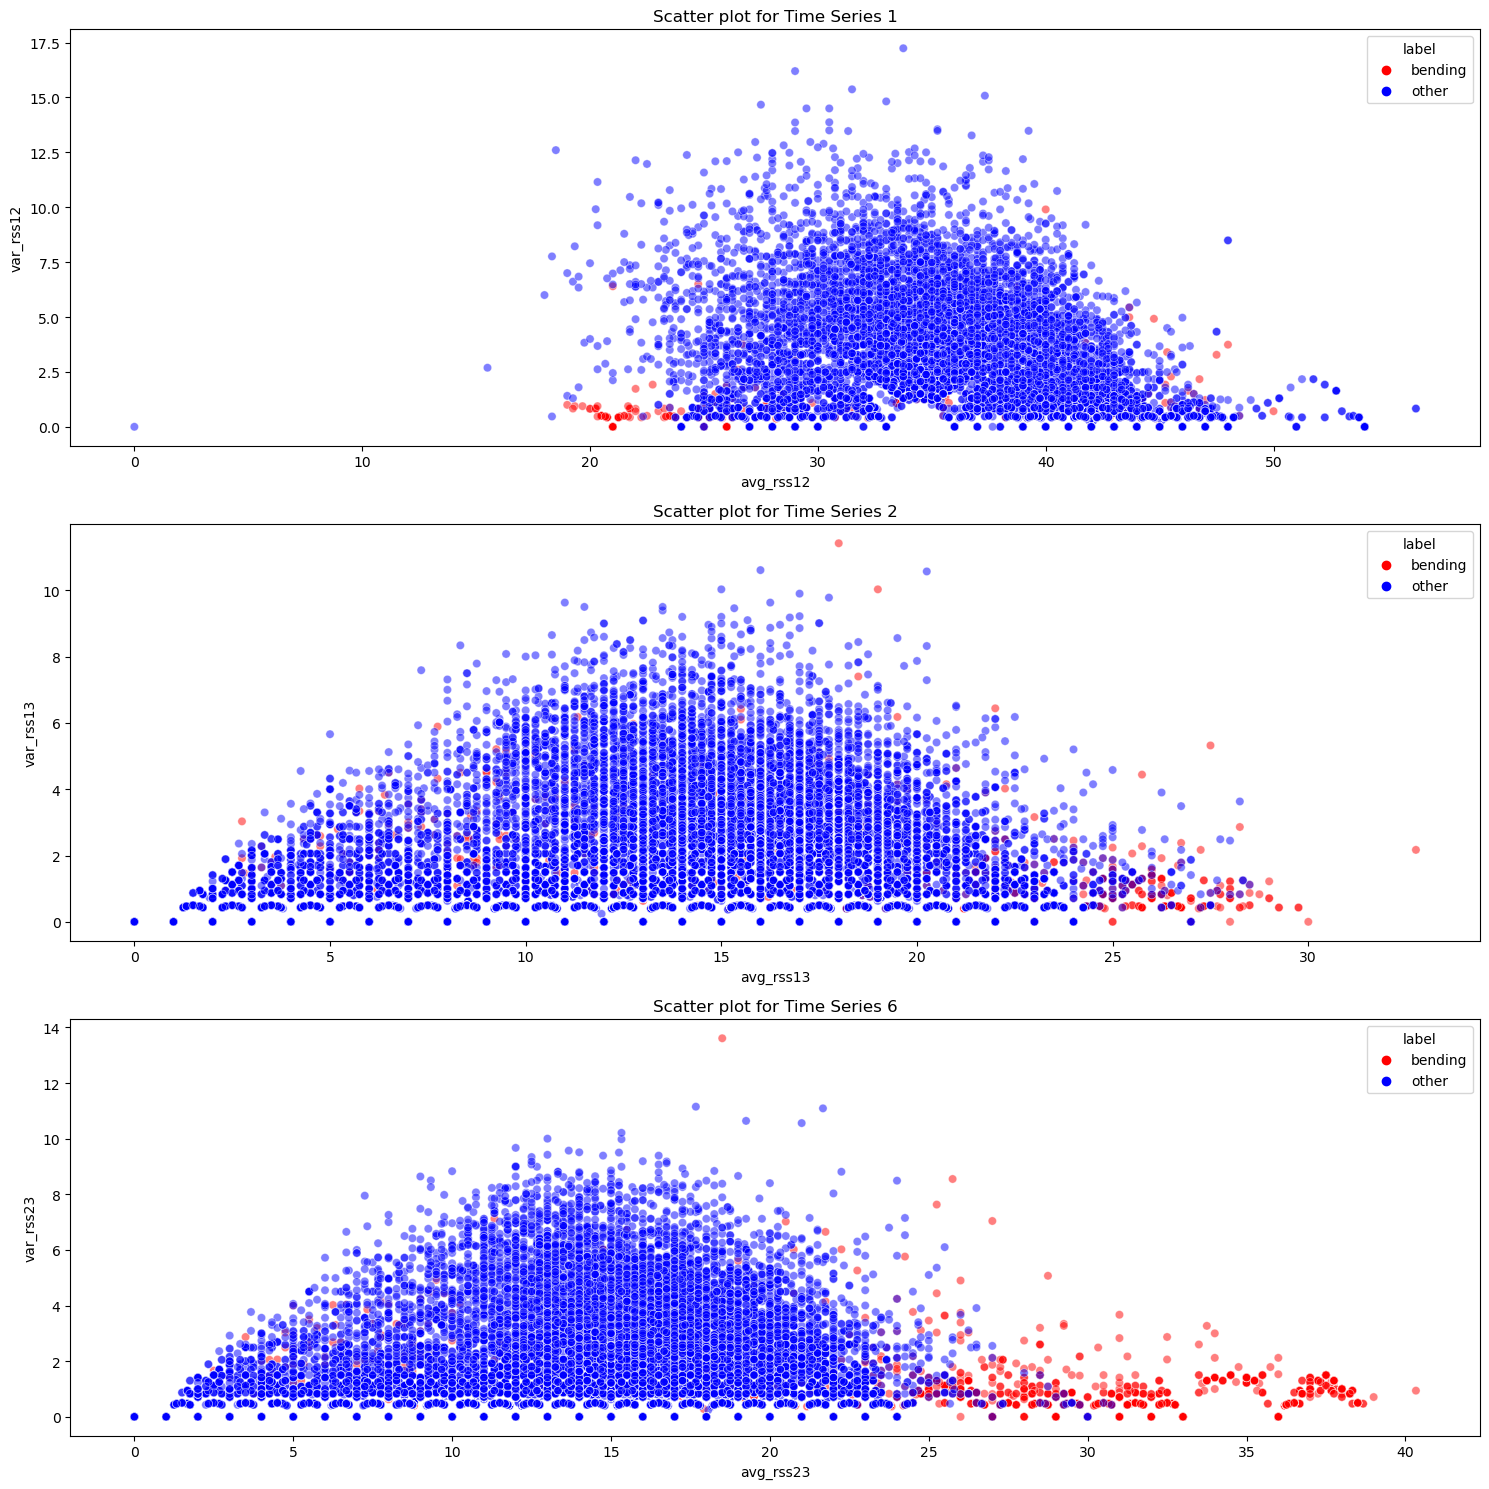

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from scipy.stats import norm

# Homework 4
# Benjamin Granat
# bgranat@usc.edu
# USC ID: 3531735770

#Load the training set
#Citations: Utilized ChatGPT for for loop structure and help with read_csv error debugging
train_dfs = []
activities = {
    "bending1": 7,
    "bending2": 6,
    "cycling": 15,
    "lying": 15,
    "sitting": 15,
    "standing": 15,
    "walking": 15
}
test_indices = {
    "bending1": [0, 1],
    "bending2": [0, 1],
    "cycling": [0, 1, 2],
    "lying": [0, 1, 2],
    "sitting": [0, 1, 2],
    "standing": [0, 1, 2],
    "walking": [0, 1, 2]
}
base_folder = "AReM"

#Function to load all activity data with activity labels
#Citations: Utilized ChatGPT for function and for loop structure
def load_activity_data_with_label(base_folder, activity_folder, num_datasets):
    data_frames = []
    for i in range(1, num_datasets + 1):
        filename = "dataset" + str(i) + ".csv"
        filepath = base_folder + "/" + activity_folder + "/" + filename
        df = pd.read_csv(filepath, skiprows=5, names=["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"], on_bad_lines='skip')
        df['activity'] = activity_folder
        data_frames.append(df)
    return data_frames
#Loading data into training data array
#Citations: Utilized ChatGPT for error-debugging and help with loading data into training data array
for activity, indices in test_indices.items():
    data_frames = load_activity_data_with_label(base_folder, activity, activities[activity])
    for i in range(activities[activity]):
        if i not in indices:
            train_dfs.append(data_frames[i])
train_df = pd.concat(train_dfs, ignore_index=True)

bending_activities = ['bending1', 'bending2']
other_activities = ['cycling', 'lying', 'sitting', 'standing', 'walking']
#Combining bending1 and bending2 activities
#Citations: Utilized ChatGPT for .apply structure and if statement structure
train_df['label'] = train_df['activity'].apply(lambda x: 'bending' if x in bending_activities else 'other')

#Extract selected features function used later in script
def extract_selected_features(df):
    selected_features = df[['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']]
    return selected_features
scatter_data = extract_selected_features(train_df)

#Scatter plots using Seaborn
#Citations: Utilized ChatGPT for seaborn plot structure and labeling
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
sns.scatterplot(data=scatter_data, x='avg_rss12', y='var_rss12', hue=train_df['label'], palette={'bending': 'red', 'other': 'blue'}, alpha=0.5)
plt.title('Scatter plot for Time Series 1')
plt.xlabel('avg_rss12')
plt.ylabel('var_rss12')
plt.subplot(3, 1, 2)
sns.scatterplot(data=scatter_data, x='avg_rss13', y='var_rss13', hue=train_df['label'], palette={'bending': 'red', 'other': 'blue'}, alpha=0.5)
plt.title('Scatter plot for Time Series 2')
plt.xlabel('avg_rss13')
plt.ylabel('var_rss13')
plt.subplot(3, 1, 3)
sns.scatterplot(data=scatter_data, x='avg_rss23', y='var_rss23', hue=train_df['label'], palette={'bending': 'red', 'other': 'blue'}, alpha=0.5)
plt.title('Scatter plot for Time Series 6')
plt.xlabel('avg_rss23')
plt.ylabel('var_rss23')
plt.tight_layout()
plt.show()

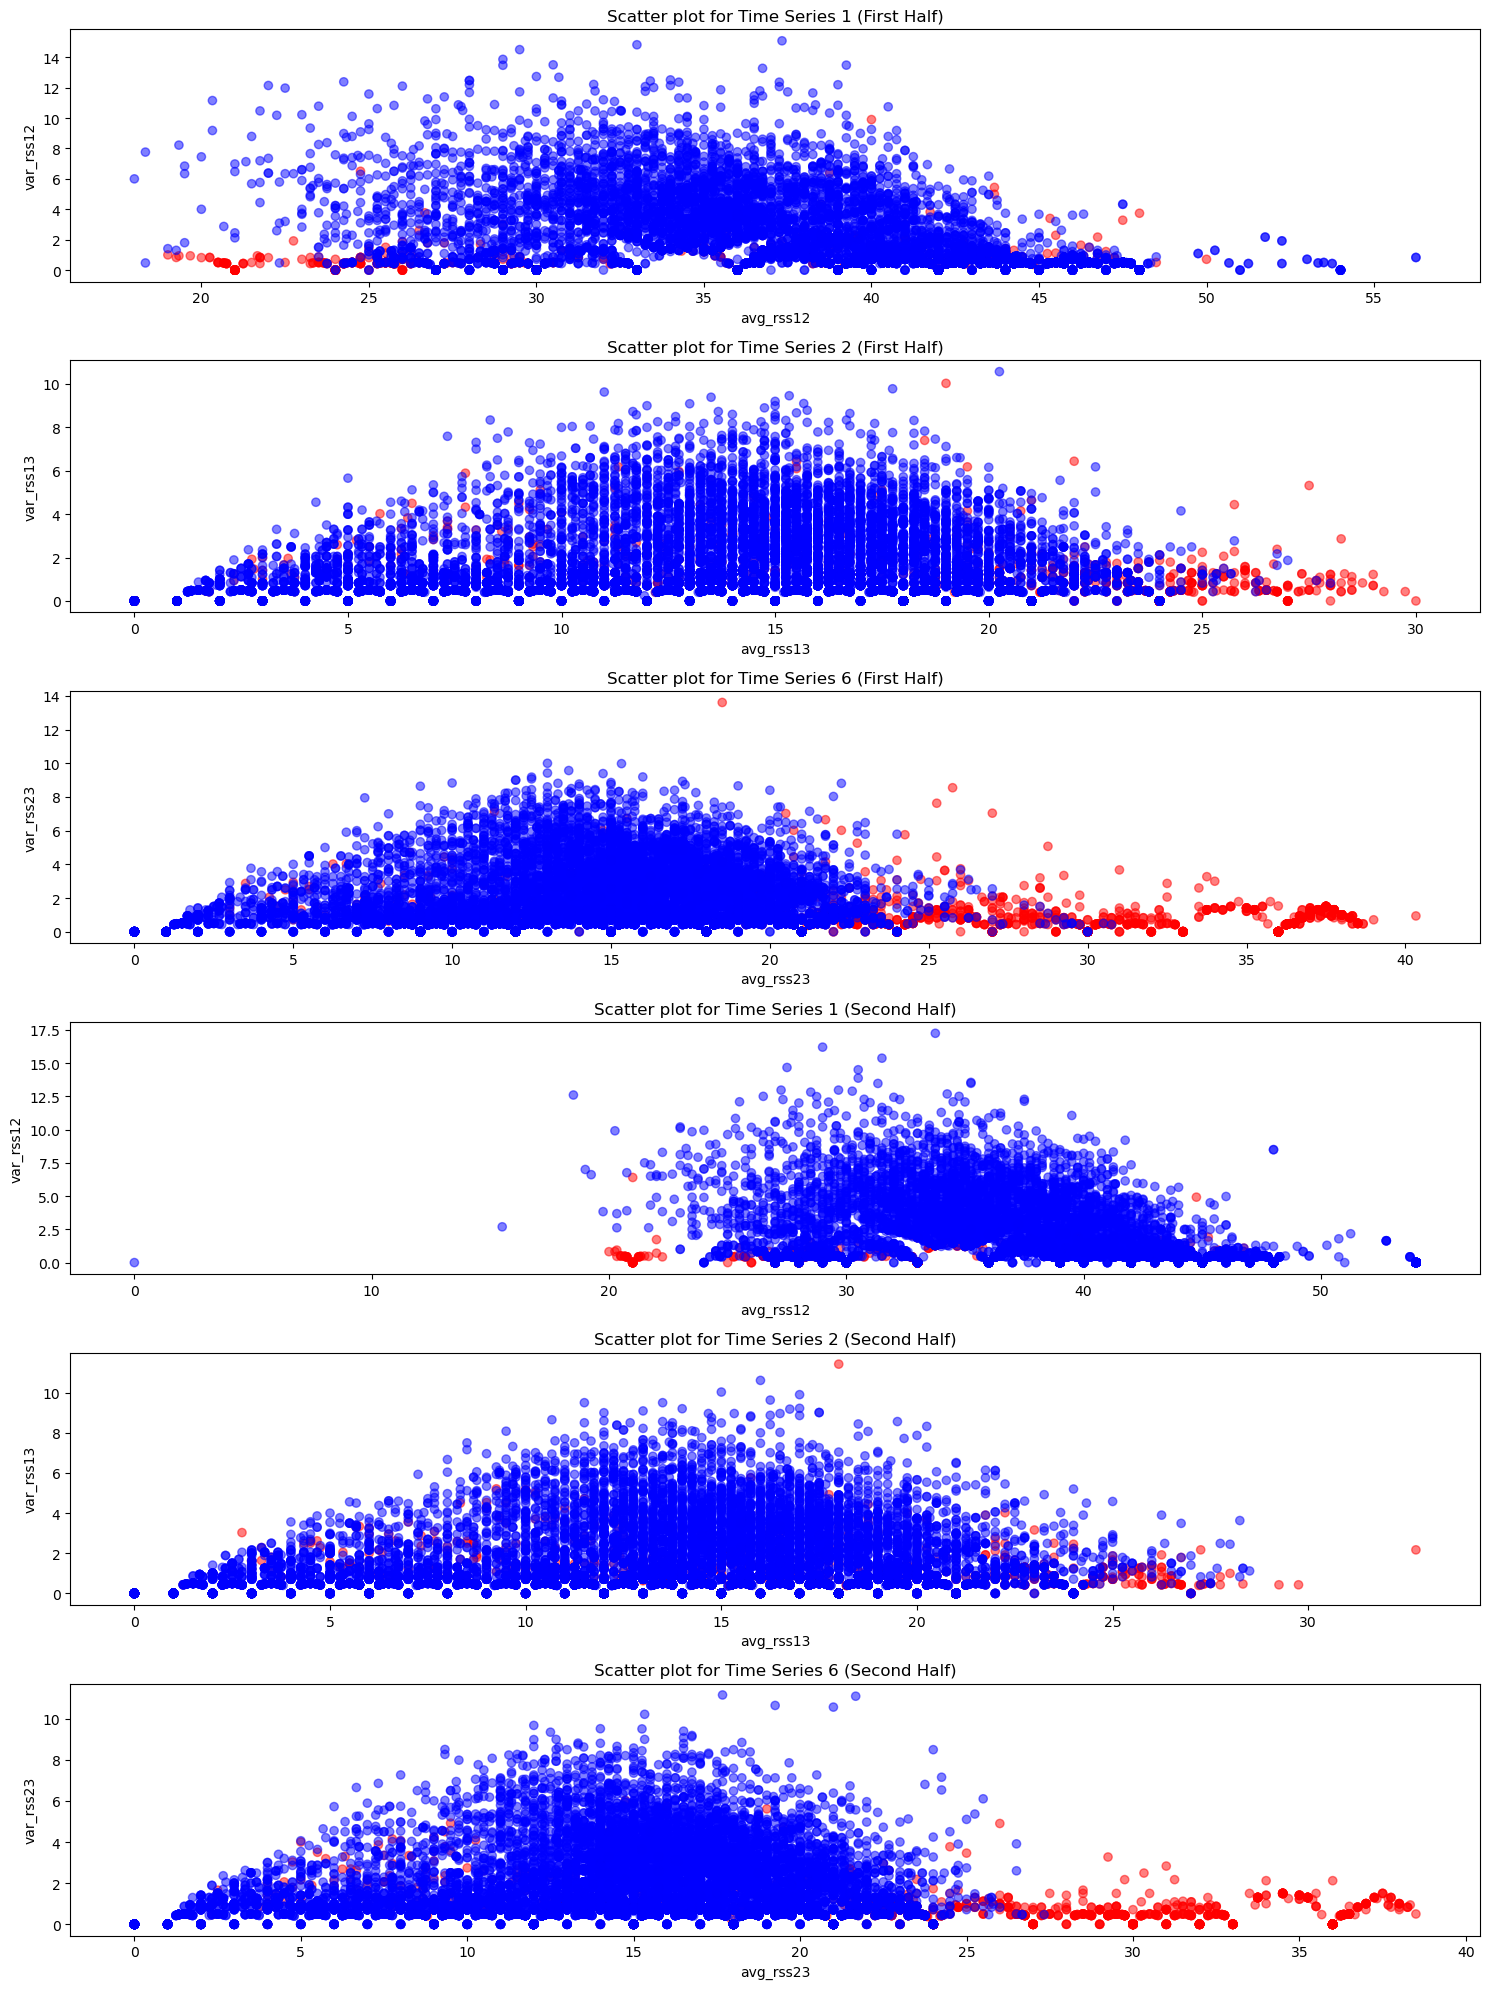

In [7]:
split_train_dfs_1 = []
split_train_dfs_2 = []

#Splitting training set into two approximately equal length time series
#Citations: Utilized ChatGPT for for loop structure and training set splitting
for df in train_dfs:
    mid_point = len(df) // 2
    df1 = df.iloc[:mid_point, :].reset_index(drop=True)
    df2 = df.iloc[mid_point:, :].reset_index(drop=True)
    split_train_dfs_1.append(df1)
    split_train_dfs_2.append(df2)

#Convert lists to DataFrames
split_train_df_1 = pd.concat(split_train_dfs_1, ignore_index=True)
split_train_df_2 = pd.concat(split_train_dfs_2, ignore_index=True)

#Filtering training data
bending_activities = ['bending1', 'bending2']
other_activities = ['cycling', 'lying', 'sitting', 'standing', 'walking']
#Combining bending1 and bending2 activities
#Citations: Utilized ChatGPT for .apply structure and if statement structure
split_train_df_1['label'] = split_train_df_1['activity'].apply(lambda x: 'bending' if x in bending_activities else 'other')
split_train_df_2['label'] = split_train_df_2['activity'].apply(lambda x: 'bending' if x in bending_activities else 'other')
scatter_data_1 = extract_selected_features(split_train_df_1)
scatter_data_2 = extract_selected_features(split_train_df_2)

#Scatter plots
#Citations: Utilized ChatGPT for plt structure and all labeling
plt.figure(figsize=(15, 20))
plt.subplot(6, 1, 1)
plt.scatter(scatter_data_1['avg_rss12'], scatter_data_1['var_rss12'], c=split_train_df_1['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 1 (First Half)')
plt.xlabel('avg_rss12')
plt.ylabel('var_rss12')
plt.subplot(6, 1, 2)
plt.scatter(scatter_data_1['avg_rss13'], scatter_data_1['var_rss13'], c=split_train_df_1['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 2 (First Half)')
plt.xlabel('avg_rss13')
plt.ylabel('var_rss13')
plt.subplot(6, 1, 3)
plt.scatter(scatter_data_1['avg_rss23'], scatter_data_1['var_rss23'], c=split_train_df_1['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 6 (First Half)')
plt.xlabel('avg_rss23')
plt.ylabel('var_rss23')
plt.subplot(6, 1, 4)
plt.scatter(scatter_data_2['avg_rss12'], scatter_data_2['var_rss12'], c=split_train_df_2['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 1 (Second Half)')
plt.xlabel('avg_rss12')
plt.ylabel('var_rss12')
plt.subplot(6, 1, 5)
plt.scatter(scatter_data_2['avg_rss13'], scatter_data_2['var_rss13'], c=split_train_df_2['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 2 (Second Half)')
plt.xlabel('avg_rss13')
plt.ylabel('var_rss13')
plt.subplot(6, 1, 6)
plt.scatter(scatter_data_2['avg_rss23'], scatter_data_2['var_rss23'], c=split_train_df_2['label'].apply(lambda x: 'red' if x == 'bending' else 'blue'), alpha=0.5)
plt.title('Scatter plot for Time Series 6 (Second Half)')
plt.xlabel('avg_rss23')
plt.ylabel('var_rss23')

plt.tight_layout()
plt.show()

Evaluating for l = 1...


/Users/bgranat/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/Users/bgranat/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bgranat/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bgranat/opt/miniconda3/lib/python3.9/site-packages/sklearn/

Cross-validation score for l = 1: nan
Evaluating for l = 2...
Cross-validation score for l = 2: 0.8660714285714286
Evaluating for l = 3...
Cross-validation score for l = 3: 0.8095238095238094
Evaluating for l = 4...
Cross-validation score for l = 4: 0.8303571428571429
Evaluating for l = 5...
Cross-validation score for l = 5: 0.8357142857142857
Evaluating for l = 6...
Cross-validation score for l = 6: 0.9305555555555556
Evaluating for l = 7...
Cross-validation score for l = 7: 0.9
Evaluating for l = 8...
Cross-validation score for l = 8: 0.9818181818181818
Evaluating for l = 9...
Cross-validation score for l = 9: 0.9833333333333334
Evaluating for l = 10...
Cross-validation score for l = 10: 0.9428571428571428
Evaluating for l = 11...
Cross-validation score for l = 11: 0.9866666666666667
Evaluating for l = 12...
Cross-validation score for l = 12: 0.9529411764705882
Evaluating for l = 13...
Cross-validation score for l = 13: 1.0
Evaluating for l = 14...
Cross-validation score for l = 14: 

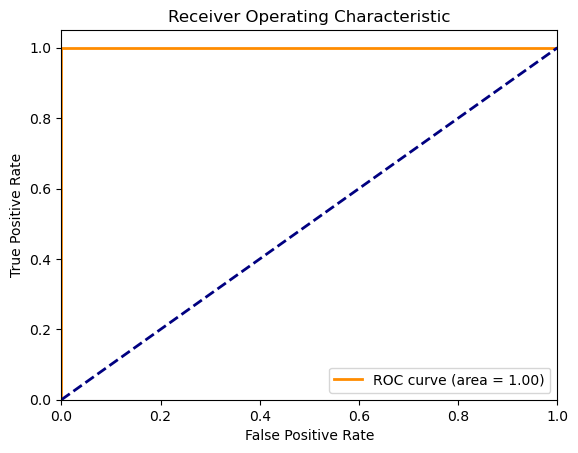

Wrong Way: Use simple K-fold cross-validation without stratification.
This can result in some folds having no samples from the minority class, leading to inaccurate and unreliable model evaluation.



In [49]:
# 2A(iii) & (iv)

#Function to split each time series into l approximately equal-length time series
#Citations: Utilized ChatGPT for functions below for function, string concatination, and for loop structures. Also used for debugging.
def split_time_series(data_frames, l):
    split_data = []
    for df in data_frames:
        length = len(df)
        split_length = length // l
        for i in range(l):
            start_index = i * split_length
            end_index = (i + 1) * split_length if i < l - 1 else length
            split_df = df.iloc[start_index:end_index, :].reset_index(drop=True)
            split_data.append(split_df)
    return split_data

#Function to calculate p-values using chi-squared test used later in the code
#Citations: Utilized ChatGPT for chi-squared test structure
def calculate_p_values(X, y):
    model = LogisticRegression(max_iter=10000).fit(X, y)
    chi2_vals = (model.coef_ ** 2).flatten()
    p_values = [stats.chi2.sf(chi2, df=1) for chi2 in chi2_vals]
    return p_values

#Function to extract selected features
def extract_selected_features(df):
    features = {}
    numerical_columns = df.select_dtypes(include=[np.number]).columns  # Select only numerical columns
    for column in numerical_columns:
        features[column + '_mean'] = df[column].mean()
        features[column + '_std'] = df[column].std()
        features[column + '_median'] = df[column].median()
        features[column + '_1st_quartile'] = df[column].quantile(0.25)
        features[column + '_3rd_quartile'] = df[column].quantile(0.75)
    return features

#Function to separate train and test data
def separate_train_test_data(data_frames, test_indices):
    train_data = []
    test_data = []
    for i in range(len(data_frames)):
        if i in test_indices:
            test_data.append(data_frames[i])
        else:
            train_data.append(data_frames[i])
    return train_data, test_data

#Load and split data
train_data = []
test_data = []
for activity, num_datasets in activities.items():
    data_frames = load_activity_data_with_label(base_folder, activity, num_datasets)
    train_frames, test_frames = separate_train_test_data(data_frames, test_indices[activity])
    train_data.extend(train_frames)
    test_data.extend(test_frames)

#Iterating over different values of l
best_l = None
best_p = None
best_score = -np.inf

#Citations: Utilized ChatGPT for if statement structure inside of the array and error-debugging throughout the for loop
for l in range(1, 21):
    print("Evaluating for l = " + str(l) + "...")
    #Split the data into l parts
    split_train_data = split_time_series(train_data, l)
    split_train_df = pd.concat(split_train_data, ignore_index=True)
    bending_activities = ['bending1', 'bending2']
    #Labelling bending activities to reference further in the code
    labels = [1 if activity in bending_activities else 0 for activity in split_train_df['activity']]
    split_train_df['label'] = labels
    features_list = []
    labels = []
    #Extracting and collecting statistical features 
    for _, group in split_train_df.groupby(split_train_df.index // (len(split_train_df) // (l * len(activities)))):
        features = extract_selected_features(group)
        features_list.append(features)
        labels.append(group['label'].iloc[0])
    #Feature dataframe creation and depositing of features
    features_df = pd.DataFrame(features_list)
    labels = np.array(labels)
    imputer = SimpleImputer(strategy='mean')
    features_df_imputed = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)
    #Regression and RFE
    log_reg = LogisticRegression(max_iter=10000)
    RFE_fx = RFE(log_reg, n_features_to_select=1)
    RFE_fx = RFE_fx.fit(features_df_imputed, labels)
    #Due to continous errors, ensuring that the number of splits is at least 2 
    #Citations: Utilized ChatGPT to fix this part by ensuring 5-fold cross-validation
    min_samples = min(np.bincount(labels))
    n_splits = max(2, min(5, min_samples))  # Ensure n_splits is at least 2
    cv = StratifiedKFold(n_splits=n_splits)
    cross_val_scores = cross_val_score(RFE_fx, features_df_imputed, labels, cv=cv)
    mean_cv_score = np.mean(cross_val_scores)
    print("Cross-validation score for l = " + str(l) + ": " + str(mean_cv_score))
    #Storage of best l and best p
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_l = l
        best_p = len(features_df.columns[RFE_fx.support_])

print("Best l: " + str(best_l))
print("Best p: " + str(best_p))

#New logistic regression model using the best l and p
split_train_data = split_time_series(train_data, best_l)
split_train_df = pd.concat(split_train_data, ignore_index=True)
labels = [1 if activity in bending_activities else 0 for activity in split_train_df['activity']]
split_train_df['label'] = labels
features_list = []
labels = []
for _, group in split_train_df.groupby(split_train_df.index // (len(split_train_df) // (best_l * len(activities)))):
    features = extract_selected_features(group)
    features_list.append(features)
    labels.append(group['label'].iloc[0])
features_df = pd.DataFrame(features_list)
labels = np.array(labels)
imputer = SimpleImputer(strategy='mean')
features_df_imputed = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)
#Citations: Utilized ChatGPT for logistic regression and RFE fitting to best l and best p. Ran into numerous errors
#along the way and used new version of final_model to adjust. 
log_reg = LogisticRegression(max_iter=10000)
RFE_fx = RFE(log_reg, n_features_to_select=best_p)
RFE_fx = RFE_fx.fit(features_df_imputed, labels)
selected_features = features_df.columns[RFE_fx.support_]
final_model = LogisticRegression(max_iter=10000)
final_model.fit(features_df_imputed[selected_features], labels)
coefficients = final_model.coef_
print("Coefficients of the selected features:\n", coefficients)
#P-values of coefficients
p_values = calculate_p_values(features_df_imputed[selected_features], labels)
print("P-values of the features:\n", p_values)
#Generating predictions and construction of confusion matrix
#Citations: Utilized ChatGPT for predict and predict_proba structure
y_pred_train = final_model.predict(features_df_imputed[selected_features])
y_pred_proba_train = final_model.predict_proba(features_df_imputed[selected_features])[:, 1]
#Confusion Matrix
conf_matrix = confusion_matrix(labels, y_pred_train)
print("Confusion Matrix:\n", conf_matrix)
#ROC and AUC curve generation
#Citations: Utilized ChatGPT for ROC and AUC curve structure as well as plotting parameters and legend/titling
fpr, tpr, _ = roc_curve(labels, y_pred_proba_train)
roc_auc = roc_auc_score(labels, y_pred_proba_train)
print("AUC: " + str(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Wrong Way: Use simple K-fold cross-validation without stratification.")
print("This can result in some folds having no samples from the minority class, leading to inaccurate and unreliable model evaluation.\n")

Cross-validation accuracy: 1.0
Test set accuracy: 0.9891304347826086
Confusion Matrix:
 [[72  0]
 [ 1 19]]
AUC: 0.975


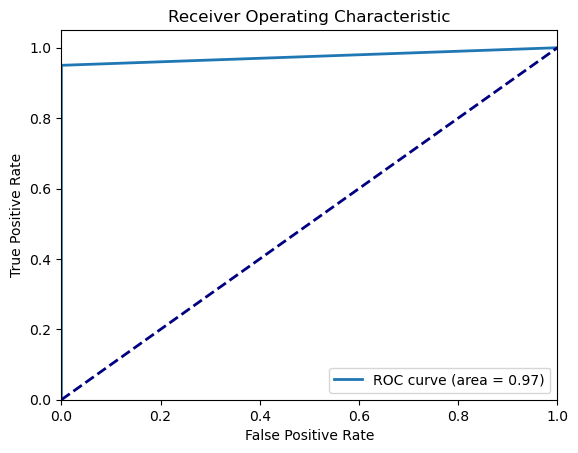

Accuracy scores were high across the board (cross-val accuracy, test-set accuracy), indicating that the classes are well-separated. I decided not to do case-controlled sampling.However, the number of false negatives is concerning. Not sure what to do in order to alleviate this issue.


In [50]:
# 2A(v) & (vi) & (vii)

#Splitting the test set into the same number of time series (best_l) as the training set
split_test_data = split_time_series(test_data, best_l)
split_test_df = pd.concat(split_test_data, ignore_index=True)

#Error debugging - needed to include this in order to avoid errors.
#Citations: Utilized ChatGPT for error debugging
if 'label' not in split_test_df.columns:
    split_test_df['label'] = split_test_df['activity'].apply(lambda x: 1 if x in bending_activities else 0)
#Extracting and collecting statistical features 
test_features_list = []
test_labels = []
for _, group in split_test_df.groupby(split_test_df.index // (len(split_test_df) // (best_l * len(activities)))):
    features = extract_selected_features(group)
    test_features_list.append(features)
    test_labels.append(group['label'].iloc[0])
test_features_df = pd.DataFrame(test_features_list)
test_labels = np.array(test_labels)
#Ensuring consistent feature names between training and test datasets - more necessary lines for error-debugging
#Citations: Utilized ChatGPT to decode errors invlved with feature storage and used help from ChatGPT
missing_cols = set(features_df.columns) - set(test_features_df.columns)
for col in missing_cols:
    test_features_df[col] = 0
test_features_df = test_features_df[features_df.columns]
test_features_df_imputed = pd.DataFrame(imputer.transform(test_features_df), columns=test_features_df.columns)
#Generating prediction
y_pred_test = final_model.predict(test_features_df_imputed[selected_features])
#Calculate accuracy
test_accuracy = accuracy_score(test_labels, y_pred_test)
#Print results
#Citations: Used ChatGPT for printing of confusion matrix and accuracy printing as well as ROC and AUC curve structure
print("Cross-validation accuracy:", best_score)
print("Test set accuracy:", test_accuracy)
#Confusion matrix calculation
conf_matrix = confusion_matrix(test_labels, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)
#ROC and AUC calculation
y_pred_prob = final_model.predict_proba(test_features_df_imputed[selected_features])[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
#Citations: Utilized ChatGPT for ROC plotting structure
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Accuracy scores were high across the board (cross-val accuracy, test-set accuracy), indicating that the classes are well-separated. I decided not to do case-controlled sampling."
      "However, the number of false negatives is concerning. Not sure what to do in order to alleviate this issue.")

In [51]:
print("After the final part of #2a, I continued to run into the same error over and over again:")
print("ValueError: Must pass 2-d input. shape=(7, 4731, 7)")
print("Despite extensive research, I was not able to fix the error and so I was not able to complete #2b or #2c whatsoever.")
print("I apologize for not being able to do this but with the number of late days I have used as well as the upcoming midterm," 
      "I decided to submit what I had.")

After the final part of #2a, I continued to run into the same error over and over again:
ValueError: Must pass 2-d input. shape=(7, 4731, 7)
Despite extensive research, I was not able to fix the error and so I was not able to complete #2b or #2c whatsoever.
I apologize for not being able to do this but with the number of late days I have used as well as the upcoming midterm,I decided to submit what I had.


In [43]:
#4
#Given values
mean_dividend = 10
mean_no_dividend = 0
variance = 36
std_dev = np.sqrt(variance)
prior_dividend = 0.8
prior_no_dividend = 0.2
x_value = 4

#Likelihoods
likelihood_dividend = norm.pdf(x_value, mean_dividend, std_dev)
likelihood_no_dividend = norm.pdf(x_value, mean_no_dividend, std_dev)

#Calculation of evidence
evidence = (likelihood_dividend * prior_dividend) + (likelihood_no_dividend * prior_no_dividend)

#Calculation of posterior probabilities
posterior_dividend = (likelihood_dividend * prior_dividend) / evidence
print("Posterior probability of issuing a dividend: {:.4f}".format(posterior_dividend))

Posterior probability of issuing a dividend: 0.7519
